# I. Data Exploration 
We are going to start with some basic data exploration to see what is in the Dataframes.
Specifically, we are looking for outliers and missing values and keeping an eye open for 
other unexpected qualities of the data. 

By the time we merge the frames and conclude the preprocessing of our dataset, we want to 
be completely familiar with the contents to avoid any surprizes in the next stages.

Next we inspect the correlation and statistical properties of the dataset and apply some dimensionality reduction and clustering to the dataset to see if we can group our subjects into subsets. 

In [1]:
# Basic tools
import os
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

# Env vars from setup for inports
load_dotenv()

True

## 1. Basics

Woookay lets go over the individual frames real quick to see whats in there. 

### 1.1 Age and Gender
This dataframe contains age and gender data, attributed to individual, pseudonomized subject, related to via the primary 'id' key.

From the following analysis we obtain:
- id: counter primary key 
- gender: 
    - binary male-female
    - close to balanced but slightly in favor of male population
    - no missing values
- age: 
    - only major up to age 85 (18 jahre ist man erwachsen in deutschland nicht 21)
    - no missing values

In [2]:
# Data file paths
data_dir = os.getenv("DATA")
age_gender_df = pd.read_csv(Path(data_dir) / "alter_geschlecht.csv")
age_gender_df = age_gender_df.sort_values(by=["id"])
age_gender_df.head()

id Geschlecht  Alter
302985   1       Male     44
416478   2       Male     76
132773   3       Male     47
52197    4       Male     21
35343    5     Female     29

In [3]:
# We could technically use the .describe(include='all') method to get all the stats at once
# but we want that sweet fine grained control allowing us to know EVERYTHING

# Age
print(f"""Alter:
- max: {age_gender_df['Alter'].max()}
- min: {age_gender_df['Alter'].min()}
- mean: {age_gender_df['Alter'].mean()}
- median: {age_gender_df['Alter'].median()}
- std: {age_gender_df['Alter'].std()}
- count: {age_gender_df['Alter'].count()}
- nancount: {age_gender_df['Alter'].isna().sum()}
""")

# Gender
print(f"""Geschlecht:
- unique: {age_gender_df['Geschlecht'].unique()}
- count: {age_gender_df['Geschlecht'].count()}
- male count: {age_gender_df['Geschlecht'].value_counts()['Male']}
- female count: {age_gender_df['Geschlecht'].value_counts()['Female']}
""")

# ID
print(f"""id:
- min: {age_gender_df['id'].min()}
- max: {age_gender_df['id'].max()}
- nunique: {age_gender_df['id'].nunique()}
- count: {age_gender_df['id'].count()}
""")

Alter:
- max: 85
- min: 20
- mean: 38.8084133300272
- median: 36.0
- std: 15.500178638692834
- count: 508146
- nancount: 0

Geschlecht:
- unique: ['Male' 'Female']
- count: 508146
- male count: 274325
- female count: 233821

id:
- min: 1
- max: 508146
- nunique: 508146
- count: 508146



### 1.2 Interest Data (Target)
This is our target dataset, containing information on wether the subject is interested in the insurance or not. From the following analysis we can take away:

- id:
    - again our primary key
    - weirdly this counts up to only 381109
- interest:
    - binary 0 or 1
    - 7 times more 0 than 1s
    - no missing values

In [4]:
interest_df = pd.read_csv(Path(data_dir) / "interesse.csv")
interest_df = interest_df.sort_values(by=["id"])
interest_df.head()

id  Interesse
0   1        1.0
1   2        0.0
2   3        1.0
3   4        0.0
4   5        0.0

In [5]:
# We could technically use the .describe(include='all') method to get all the stats at once
# but we want that sweet fine grained control allowing us to know EVERYTHING

# Interest
print(f"""Interesse:
- unique: {interest_df['Interesse'].unique()}  
- count: {interest_df['Interesse'].count()}
- 1 count: {interest_df['Interesse'].value_counts()[1]}
- 0 count: {interest_df['Interesse'].value_counts()[0]}
- nancount: {interest_df['Interesse'].isna().sum()}
""")

# ID
print(f"""id:
- min: {interest_df['id'].min()}
- max: {interest_df['id'].max()}
- nunique: {interest_df['id'].nunique()}
- count: {interest_df['id'].count()}
""")

Interesse:
- unique: [1. 0.]  
- count: 381109
- 1 count: 46710
- 0 count: 334399
- nancount: 0

id:
- min: 1
- max: 381109
- nunique: 381109
- count: 381109



### 1.3 Insurance Features
This Dataframe has a bit more content. That means we are going to use the big stick and slap it with .describe.
We quickly notice that most features are categorical with less than 4 categories, which is good for one-hot encoding.
Regional code and sales channels are categorical but ordingal encoding, even though not appropriate will have to do.

- id:
    - full range counter primary key again

- Driver's License
    - binary 0-1
    - mostly 1

- Regional code:
    - 53 different codes

- Previous Insurance:
    - binary 0-1
    - close to being balanced

- Vehicle Age:
    - most vehicles are 1< x <2 years old with very few older than two years

- sales channel:
    - 157 different channels

In [6]:
insurance_features_df = pd.read_csv(Path(data_dir) / "rest.csv", delimiter=";")
insurance_features_df = insurance_features_df.sort_values(by=["id"])

dtype_mapping = {
    "Fahrerlaubnis": "category", 
    "Vorversicherung": "category", 
    "Alter_Fzg": "category", 
    "Vorschaden": "category", 
    "Vertriebskanal": "category"
}
insurance_features_df = insurance_features_df.astype(dtype_mapping)
insurance_features_df["Regional_Code"] = insurance_features_df["Regional_Code"].astype(int).astype("category"
                                                                                                   )
insurance_features_df.head()

Fahrerlaubnis Regional_Code Vorversicherung  Alter_Fzg Vorschaden  \
163016             1            28               0  > 2 Years        Yes   
375123             1             3               0   1-2 Year         No   
56906              1            28               0  > 2 Years        Yes   
352098             1            11               1   < 1 Year         No   
122431             1            41               1   < 1 Year         No   

        Jahresbeitrag Vertriebskanal  Kundentreue  id  
163016        40454.0           26.0          217   1  
375123        33536.0           26.0          183   2  
56906         38294.0           26.0           27   3  
352098        28619.0          152.0          203   4  
122431        27496.0          152.0           39   5

In [7]:
insurance_features_df.describe()

Jahresbeitrag    Kundentreue             id
count  508146.000000  508146.000000  508146.000000
mean    30554.453041     154.340123  254073.500000
std     17146.574625      83.668793  146689.259281
min      2630.000000      10.000000       1.000000
25%     24381.000000      82.000000  127037.250000
50%     31661.000000     154.000000  254073.500000
75%     39403.750000     227.000000  381109.750000
max    540165.000000     299.000000  508146.000000

In [8]:
insurance_features_df.describe(include='category')

Fahrerlaubnis  Regional_Code  Vorversicherung Alter_Fzg Vorschaden  \
count          508146         508146           508146    508146     508146   
unique              2             53                2         3          2   
top                 1             28                0  1-2 Year        Yes   
freq           507097         141937           275076    267015     256248   

        Vertriebskanal  
count         508146.0  
unique           157.0  
top              152.0  
freq          179523.0

In [9]:
print(f"""Alter_Fzg:
- unique: {insurance_features_df['Alter_Fzg'].unique()}
- < 1 Year count: {insurance_features_df['Alter_Fzg'].value_counts()['< 1 Year']}
- > 2 Years count: {insurance_features_df['Alter_Fzg'].value_counts()['> 2 Years']}
""")

print(f"""Vorschaden:
- unique: {insurance_features_df['Vorschaden'].unique()}
- No count: {insurance_features_df['Vorschaden'].value_counts()['No']}
""")

print(f"""Total nans:
- total nan count: {insurance_features_df.isna().sum().sum()}      
""")

Alter_Fzg:
- unique: ['> 2 Years', '1-2 Year', '< 1 Year']
Categories (3, object): ['1-2 Year', '< 1 Year', '> 2 Years']
- < 1 Year count: 219805
- > 2 Years count: 21326

Vorschaden:
- unique: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']
- No count: 251898

Total nans:
- total nan count: 0      



## 2. Corelation & Clustering

Lets look at some intrinsic features of the data. First we'll merge then we'll cluster the data. Merging will reduce the set size, since somehoooow the target is the frame with missing entry, but this can't stop us so lets go.

In [10]:
# Throwing it together (may the lord come get me if this is wrong and I'm messing up already)
dataset_df = pd.merge(left=age_gender_df, right=interest_df, on="id")
dataset_df = pd.merge(left=dataset_df, right=insurance_features_df, on="id")
dtype_mapping = {
    "Geschlecht": "category",
    "Interesse": "int" # unnecessary but OCDed here
}
dataset_df = dataset_df.astype(dtype_mapping)
dataset_df.head()


### 2.1 Corelation

Nexxxt we are rolling out that sweet correlation tile map. But first we will have to make everything floatable, meaning that all the categoricals will be ordinated.

In [11]:
# categorical to ordinal encoding
ordinated_df = pd.DataFrame()
for col in dataset_df:
    if dataset_df[col].dtype.name == "category":
        ordinated_df[col] = dataset_df[col].cat.codes
    else:
        ordinated_df[col] = dataset_df[col]


<Axes: >

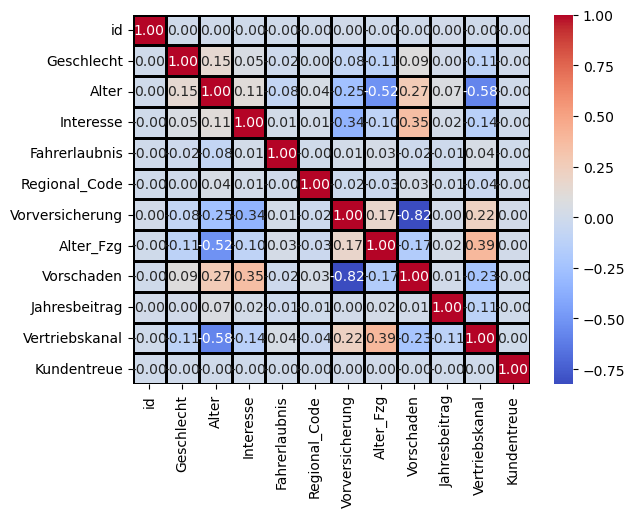

In [12]:
sns.heatmap(ordinated_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2, linecolor='black')

Aha look at these Schlawieners!, Vorversicherung and Vorschaden are negatively, strongly correlated (I have no idea what this means in the real world because I do not have a dirvers license but I know the language of data). 

Next we see that the age and the sales channel correlate. Half the correlation is found between sales channel and preinsurance. 

### 2.2 Dimensonality Reduction & Clustering

Now that we know what is happening between the features, we need to learn what is happening between the subjects. Are there any subgroups with similar behaviours we will be able to leverage? 
Let's jump right in. First, the data is sensitive to the feature scale, so let's normalize them:

In [13]:
# Let's start by scaling the data (no feature can rule them all)
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_df = pd.DataFrame()
scaled_df = pd.DataFrame(scaler.fit_transform(ordinated_df), columns=ordinated_df.columns)
scaled_df = scaled_df.drop(columns=["id"])
scaled_df.head()


Geschlecht     Alter  Interesse  Fahrerlaubnis  Regional_Code  \
0    0.921545  0.333777   2.675639       0.046208       0.121784   
1    0.921545  2.396751  -0.373742       0.046208      -1.767879   
2    0.921545  0.527181   2.675639       0.046208       0.121784   
3    0.921545 -1.148985  -0.373742       0.046208      -1.163187   
4   -1.085134 -0.633242  -0.373742       0.046208       1.104409   

   Vorversicherung  Alter_Fzg  Vorschaden  Jahresbeitrag  Vertriebskanal  \
0        -0.919638   2.568150    0.990294       0.574539       -1.585159   
1        -0.919638  -0.893873   -1.009801       0.172636       -1.585159   
2        -0.919638   2.568150    0.990294       0.449053       -1.585159   
3         1.087384   0.837139   -1.009801      -0.113018        0.740562   
4         1.087384   0.837139   -1.009801      -0.178259        0.740562   

   Kundentreue  
0     0.748795  
1     0.342443  
2    -1.521998  
3     0.581474  
4    -1.378580

Next, the clustering will not provide us with a visual insight, if our brain and computer cannot understand and represent them. Therefore, let's reduce the dimensionality to 3D. My kernel crashed a few times, so we do that on a reduced sample set. 

The following function helps us represent clusters:

In [38]:
from utils.plotting import plot_clusters


**PCA** 

First, lets plot the PCA with not interested and interested subjects. It imediately becomes visible, that the there are at least four clusters, where one of them represents the interested populations

In [50]:
from sklearn.decomposition import PCA

subset_df = scaled_df.sample(n=10000, random_state=42)
interesse_sr = subset_df['Interesse'].values
subset_df = subset_df.drop(columns='Interesse')

pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(subset_df.copy()), columns=["pc1", "pc2"])
pca_df['Interesse'] = interesse_sr
plot_clusters(pca_df, "pc1", "pc2", "Interesse")


**t-SNE**

This approach is more computationally demanding, as we need to compute the pair-wise distances of all the points in the cloud. However, we immediately see, that the clustering yields a more fine-grained result. Where previously some points looked like outliers, the cluster now seem to be cleanly separable.

In [52]:
from sklearn.manifold import TSNE
# Parameters for t-SNE
n_components = 2
perplexity = 30
learning_rate = 'auto'

# Apply t-SNE to the entire dataset
tsne = TSNE(n_components=n_components,
            perplexity=perplexity,
            learning_rate=learning_rate,
            random_state=42)

# Creating a DataFrame from the t-SNE results
tsne_df = pd.DataFrame(tsne.fit_transform(subset_df) , columns=['pc1', 'pc2'])
tsne_df['Interesse'] = interesse_sr
plot_clusters(tsne_df, "pc1", "pc2", "Interesse")


**K-Means**

Finally, we apply unparametric clustering. I am personally an autoencode/restricted boltzman machine enthousiast but let's not get ahead of ourselves. An easy application of k-means shows, that the clustering method is unsuitable to detect these non-circular blobs.

In [53]:
from sklearn.cluster import KMeans
# Sample random data from your PCA-transformed DataFrame
subset_df = pca_df.sample(n=10000, random_state=42)

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_df)
kmean_df = pca_df.copy()
kmean_df["Cluster"] = clusters
plot_clusters(kmean_df, "pc1", "pc2", "Cluster")


**HDBSCAN**

AlsoI chose HDBSCAN over DBSCAN, because DBSCAN would eat up all of my 48GB of RAM which its simply excessive. This method is better at blob clustering, and we can see a clean separation with some floating outlier clusters

In [54]:
from sklearn.cluster import HDBSCAN
# Sample random data from your PCA-transformed DataFrame
subset_df = pca_df.sample(n=10000, random_state=42)

# Apply K-Means
dbscan = HDBSCAN(min_samples=10, alpha=0.5)
clusters = dbscan.fit_predict(pca_df)
dbscan_pca_df = pca_df.copy()
dbscan_pca_df["Cluster"] = clusters
plot_clusters(dbscan_pca_df, "pc1", "pc2", "Cluster")

Applied to the t-SNE results, we see a clean separation in the positive region

In [55]:
from sklearn.cluster import HDBSCAN
# Sample random data from your PCA-transformed DataFrame
subset_df = pca_df.sample(n=10000, random_state=42)

# Apply K-Means
dbscan = HDBSCAN(min_samples=10, alpha=0.5, min_cluster_size=100)
clusters = dbscan.fit_predict(tsne_df)
dbscan_tsne_df = tsne_df.copy()
dbscan_tsne_df["Cluster"] = clusters
plot_clusters(dbscan_tsne_df, "pc1", "pc2", "Cluster")

In [ ]:
dataset_df.to_csv(Path(data_dir) / "dataset.csv", index=False)